### Betfair Historical Data large dataset creation
1. Following `2_betfair_advanced_data_test.ipynb` steps to download historical data
2. Iterating the stream through a list of files to create a dataset containing multiple events and race days


To connect to the Betfair API through betfairlightweight, you must have first set up your API certificates and saved the login details in dictionary format in a file called `api_logins.json` in the project home directory (`/betfair_project`). The following connects and should return `<LoginResource>` if successful.

In [2]:
import betfairlightweight
from betfairlightweight import filters
import pandas as pd
import numpy as np
import os
import datetime
import json
from pathlib import Path, PurePath #To define open and save locations that are cross-compatible between Windows/Linux
from bz2 import BZ2File #To unzip the Betfair data from its downloaded format
import matplotlib.pyplot as plt

project_dir = Path.cwd().parents[1]
logins_dir = project_dir / 'api_logins.json'

with open(logins_dir) as f:
    login_dict =  json.load(f)
    
trading = betfairlightweight.APIClient(username=login_dict['my_username'],
                                       password=login_dict['my_password'],
                                       app_key=login_dict['my_app_key'],
                                       certs=login_dict['certs_path'])

trading.login()

<LoginResource>

To perform the following, you must have purchased data from the [Betfair Historical data service](https://historicdata.betfair.com/#/home). Advanced data for all sports has been offered for free for Jan - May 2020. To understand more about what different packages of data include, look in the data dictionaries folder in this project. The following lists the data that you have purchased on your Betfair account. Since data is purchased by month, that is how it is represented here:

In [3]:
my_data = trading.historic.get_my_data()
for i in my_data:
    print(i)

{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-01-01T00:00:00', 'purchaseItemId': 42364}
{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-02-01T00:00:00', 'purchaseItemId': 42364}
{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-03-01T00:00:00', 'purchaseItemId': 42364}
{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-04-01T00:00:00', 'purchaseItemId': 41549}
{'sport': 'Horse Racing', 'plan': 'Advanced Plan', 'forDate': '2020-05-01T00:00:00', 'purchaseItemId': 41549}
{'sport': 'Horse Racing', 'plan': 'Basic Plan', 'forDate': '2016-01-01T00:00:00', 'purchaseItemId': 25202}
{'sport': 'Horse Racing', 'plan': 'Basic Plan', 'forDate': '2017-06-01T00:00:00', 'purchaseItemId': 770}
{'sport': 'Horse Racing', 'plan': 'Basic Plan', 'forDate': '2018-01-01T00:00:00', 'purchaseItemId': 24527}
{'sport': 'Horse Racing', 'plan': 'Basic Plan', 'forDate': '2018-02-01T00:00:00', 'purchaseItemId': 24527}
{'sport': 'Horse Racing'

The following selects just the data for from 01/01/20 to 01/03/20 and returns a dictionary of the contents of the data which we go on to use to download specific country/race/market types, and tells us the size of the entire selection:

In [4]:
collection_options = trading.historic.get_collection_options(
    "Horse Racing", "Advanced Plan", 1, 1, 2020, 1, 3, 2020
)

print(collection_options)

basket_size = trading.historic.get_data_size(
    "Horse Racing", "Advanced Plan", 1, 1, 2020, 1, 3, 2020
)
print(basket_size)

{'marketTypesCollection': [{'name': '', 'count': 1998}, {'name': 'ANTEPOST_WIN', 'count': 22}, {'name': 'DAILY_WIN_DIST', 'count': 1}, {'name': 'EACH_WAY', 'count': 1788}, {'name': 'FORECAST', 'count': 438}, {'name': 'MATCH_BET', 'count': 1692}, {'name': 'OTHER_PLACE', 'count': 4746}, {'name': 'PLACE', 'count': 9161}, {'name': 'RACE_WIN_DIST', 'count': 175}, {'name': 'REV_FORECAST', 'count': 784}, {'name': 'WIN', 'count': 11923}, {'name': 'WITHOUT_FAV', 'count': 306}], 'countriesCollection': [{'name': 'AE', 'count': 511}, {'name': 'AU', 'count': 11874}, {'name': 'ES', 'count': 6}, {'name': 'FR', 'count': 549}, {'name': 'GB', 'count': 10230}, {'name': 'HK', 'count': 1}, {'name': 'IE', 'count': 2147}, {'name': 'NZ', 'count': 2016}, {'name': 'SA', 'count': 44}, {'name': 'SG', 'count': 314}, {'name': 'US', 'count': 4038}, {'name': 'ZA', 'count': 1304}], 'fileTypeCollection': [{'name': 'E', 'count': 1998}, {'name': 'M', 'count': 31036}]}
{'totalSizeMB': 5731, 'fileCount': 33034}


To dig into particular dates, countries, race types and market types we use `.get_file_list()`, specifying our filtering parameters. For example, you can see above that within the sub-dictionary for `'marketTypesCollection'` we have `'WIN'`, among others. The following retrieves a list of the event files that match these parameters. We select only data for 01/02/20, for the `'WIN'` market only and in `'GB'`.

In [5]:
file_list = trading.historic.get_file_list(
    "Horse Racing",
    "Advanced Plan",
    from_day=1,
    from_month=2,
    from_year=2020,
    to_day=1,
    to_month=2,
    to_year=2020,
    market_types_collection=["WIN"],
    countries_collection=["GB"],
    file_type_collection=["M"]\
    ,
)
print(file_list)

['/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130661.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096552.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678828/1.168136214.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/2/29678760/1.168133543.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130666.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096559.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678828/1.168136219.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130671.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/2/29678760/1.168133548.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096566.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678828/1.168136224.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/2/29678760/1.168133553.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130676.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168130245.bz2', '/xds

To downoad a file, `download_file()` is used, where we specify the download location (on Betfair) in `file_path` and the directory to which it is saved in `store_directory`. The filename is kept as is from Betfair. We both download the file and use the command to assign the file's location to the variable `download` so we can use it in subsequent operations. `file_path` below is a list input over which we iterate `.download_file()`.

In [6]:
data_dir = project_dir / 'data' / 'raw' / 'api'

available_files = file_list

print(available_files)

downloaded_files = [] #list of directories of each download

for file in available_files:
    download = trading.historic.download_file(file_path = file, store_directory = data_dir)
    print(download)
    downloaded_files.append(download)

['/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130661.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096552.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678828/1.168136214.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/2/29678760/1.168133543.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130666.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096559.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678828/1.168136219.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130671.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/2/29678760/1.168133548.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168096566.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678828/1.168136224.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/2/29678760/1.168133553.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29678694/1.168130676.bz2', '/xds_nfs/edp_processed/ADVANCED/2020/Feb/1/29677422/1.168130245.bz2', '/xds

The downloaded file is .json formatted compressed in a bzip2 (.bz2) folder. The following extracts the file where it is downloaded. It is given no file extension, however it remains in .txt format and is readable in any text reader.

In [7]:
extracted_files = []

for file in downloaded_files:
    zipfile = BZ2File(file) # open the file
    data = zipfile.read() # get the decompressed data
    newfilepath = file.split('.bz2')[0] # removing the extension and saving without a filetype
    open(newfilepath, 'wb').write(data) # write an uncompressed file
    extracted_files.append(newfilepath)
    zipfile.close()
    
print(extracted_files)

['/Users/tombardrick/Documents/projects/betfair/betfair_project/data/raw/api/1.168130661', '/Users/tombardrick/Documents/projects/betfair/betfair_project/data/raw/api/1.168096552', '/Users/tombardrick/Documents/projects/betfair/betfair_project/data/raw/api/1.168136214', '/Users/tombardrick/Documents/projects/betfair/betfair_project/data/raw/api/1.168133543', '/Users/tombardrick/Documents/projects/betfair/betfair_project/data/raw/api/1.168130666', '/Users/tombardrick/Documents/projects/betfair/betfair_project/data/raw/api/1.168096559', '/Users/tombardrick/Documents/projects/betfair/betfair_project/data/raw/api/1.168136219', '/Users/tombardrick/Documents/projects/betfair/betfair_project/data/raw/api/1.168130671', '/Users/tombardrick/Documents/projects/betfair/betfair_project/data/raw/api/1.168133548', '/Users/tombardrick/Documents/projects/betfair/betfair_project/data/raw/api/1.168096566', '/Users/tombardrick/Documents/projects/betfair/betfair_project/data/raw/api/1.168136224', '/Users/t

## Using stream listener to read extracted data

We now have a readable raw text file in Betfair's dictionary format. To interpret the data with python, betfairlightweight includes a stream listener which will interpret the input of historical data in the same way that it does for live data. The below is edited from [here](https://github.com/liampauling/betfair/blob/104ff4cb8734038cb9351e74d16dc7bd018111bc/examples/examplestreaminghistorical.py). 

This finds the chosen variables in the data file and outputs them in a .csv format in output.txt. Note: output.txt is ignored by git and is not uploaded into the repository.

In [8]:
from betfairlightweight import StreamListener
from betfairlightweight.streaming.stream import MarketStream

class HistoricalStream(MarketStream):
    # create custom listener and stream

    def __init__(self, listener):
        super(HistoricalStream, self).__init__(listener)

    def on_process(self, market_books):
        with open("output.txt", "a") as output:
            for market_book in market_books:
                for runner in market_book.runners:

                    # how to get runner details from the market definition
                    market_def = market_book.market_definition
                    runners_dict = {
                        (runner.selection_id, runner.handicap): runner
                        for runner in market_def.runners
                    }
                    runner_def = runners_dict.get(
                        (runner.selection_id, runner.handicap)
                    )

                    output.write(
                        "%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s\n"
                        % (
                            market_book.publish_time, #datetime.datetime
                            market_book.market_id, #float
                            market_book.status, #unicode
                            market_book.inplay, #bool
                            runner.selection_id, #int
                            runner.last_price_traded or "", #float
                            runner.total_matched or "", #float
                            runner.sp.actual_sp or "", #float
                            runner.adjustment_factor or "", #float
                            runner.handicap or "", #float
                            market_book.number_of_active_runners or "", #int
                            runner.status,
                            market_book.total_matched or "", #float
                        )
                    )


class HistoricalListener(StreamListener):
    def _add_stream(self, unique_id, stream_type):
        if stream_type == "marketSubscription":
            return HistoricalStream(self)
        
listener = HistoricalListener(max_latency=None)

Iterating the Historical Listener through the list of `extracted_files`. For the full day of racing 01/02/20, `output.txt` is 493mb.

In [9]:
with open("output.txt", "w") as output:
    output.write("Time,MarketId,Status,Inplay,SelectionId,LastPriceTraded,TotalMatched,Sp,\
    AdjFactor,Handicap,NumRunnersActive,RunnerStatus,MktTotalMatched\n")
    pass

for file in extracted_files:
    stream = trading.streaming.create_historical_stream(
        directory=file,
        listener=listener,
    )
    stream.start()

Delete all downloaded files:

In [10]:
for file in downloaded_files:
    file = Path(file)
    file.unlink()
    
for file in extracted_files:
    file = Path(file)
    file.unlink()

We can now read output.txt with pandas.

In [11]:
df = pd.read_csv('output.txt')
df.head()

,Time,MarketId,Status,Inplay,SelectionId,LastPriceTraded,TotalMatched,Sp,AdjFactor,Handicap,NumRunnersActive,RunnerStatus,MktTotalMatched
0,2020-01-31 11:41:45.697000,1.168131,OPEN,False,25545675,NaN,NaN,NaN,5.95,NaN,6.0,ACTIVE,NaN
1,2020-01-31 11:41:45.697000,1.168131,OPEN,False,25238892,NaN,NaN,NaN,30.53,NaN,6.0,ACTIVE,NaN
2,2020-01-31 11:41:45.697000,1.168131,OPEN,False,24707172,NaN,NaN,NaN,7.01,NaN,6.0,ACTIVE,NaN
3,2020-01-31 11:41:45.697000,1.168131,OPEN,False,24420205,NaN,NaN,NaN,8.45,NaN,6.0,ACTIVE,NaN
4,2020-01-31 11:41:45.697000,1.168131,OPEN,False,26314798,NaN,NaN,NaN,33.12,NaN,6.0,ACTIVE,NaN


In [12]:
df.describe() #descriptive statistics for this data.

,MarketId,SelectionId,LastPriceTraded,TotalMatched,Sp,AdjFactor,Handicap,NumRunnersActive,MktTotalMatched
count,3.890835e+06,3.890835e+06,3.639208e+06,3.639208e+06,79644.000000,3.890835e+06,0.0,3.890519e+06,3.838611e+06
mean,1.168125e+00,1.524085e+07,3.855194e+01,5.413361e+03,43.653650,1.085089e+01,NaN,1.032114e+01,4.778537e+04
std,1.537387e-05,7.146781e+06,1.112722e+02,1.962085e+04,120.488429,9.768245e+00,NaN,3.212152e+00,9.527373e+04
min,1.168097e+00,4.200000e+02,1.010000e+00,4.000000e-02,1.280000,1.000000e-01,NaN,3.000000e+00,4.000000e-01
25%,1.168131e+00,1.016371e+07,6.800000e+00,1.638100e+02,6.400000,4.120000e+00,NaN,8.000000e+00,3.993710e+03
50%,1.168133e+00,1.424606e+07,1.200000e+01,9.516000e+02,11.610000,8.650000e+00,NaN,1.000000e+01,1.524893e+04
75%,1.168134e+00,2.140262e+07,2.700000e+01,3.663760e+03,30.000000,1.428000e+01,NaN,1.200000e+01,4.460551e+04
max,1.168136e+00,2.771821e+07,1.000000e+03,6.559295e+05,1000.000000,7.471000e+01,NaN,1.700000e+01,1.250210e+06


### Creating variables for better analysis

To understand the evolution of matches at each price, we can create `TradeSize` by looking at the change in `TotalMatched` grouped by `LastPriceTraded`.

In [13]:
df['TradeSize'] = df.groupby(['MarketId','SelectionId', 'LastPriceTraded'])['TotalMatched'].diff()

In order to make race timeseries data comparable between events, we need an indicator of what stage the market is in. For example, betting behaviour is very different when the market is first created compared to in the 5 minutes before the off, or compared to in play. A logical anchoring point is the moment in which the race starts, at which point BSP is also defined.

`TimeIndex` is created with time-zero defined at the second where `Inplay == True` for the first time for each `MarketId`, counting positively and negatively in either direction **in seconds**. 

In [14]:
# df['InplayBool'] = (df['Inplay'] == True) * 1
# df['InplayBool'] = df['InplayBool'].diff()

# race_start = df.iloc[df.index[df['InplayBool'] == 1.0].tolist(), 0].tolist()
# race_start_index = df.index[df['InplayBool'] == 1.0].tolist()
# market_ids = df['MarketId'].unique().tolist()

# del df['InplayBool']

# print(race_start)
# print(race_start_index)
# print(market_ids)

In [15]:
# original

In [16]:
# %%timeit

# df2 = df.iloc[0:0]
# df2['TimeIndex'] = None

# for market, t_0 in zip(market_ids, race_start):
#     df_temp = df[df['MarketId'] == market].reset_index()
#     df_temp['TimeIndex'] = df_temp['Time'].apply(lambda x: (datetime.datetime.strptime(x[:19], "%Y-%m-%d %H:%M:%S") - datetime.datetime.strptime(t_0[:19], "%Y-%m-%d %H:%M:%S")))
#     df2 = pd.concat([df2, df_temp])

# df2['TimeIndex'] = df2['TimeIndex'].apply(lambda x: int(pd.Timedelta.total_seconds(x)))

# del df2['index']

In [17]:
# test

In [18]:
# del df2 # free up memory for test

In [19]:
%time

# copying df
df_test = df.copy() # test on sample?

# converting to datetime
df_test['Time'] = pd.to_datetime(df['Time'], format="%Y-%m-%d %H:%M:%S", errors='coerce')

# calculating inplay start for each race (assigning to new columns)
df_test['start_time'] = df_test['Time'].where(df_test['Inplay'] == True).groupby(df_test['MarketId']).transform('min')

# calculating difference between each time point and start time
df_test['time_dif'] = (df_test['Time'] - df_test['start_time']).astype('timedelta64[s]')

CPU times: user 11 µs, sys: 40 µs, total: 51 µs
Wall time: 85.8 µs


In [20]:
df_test[['Time', 'start_time', 'time_dif']].sample(15)

,Time,start_time,time_dif
3289681,2020-02-01 16:25:14.018,2020-02-01 17:46:16.001,-4862.0
2579559,2020-01-31 23:28:28.470,2020-02-01 16:14:12.423,-60344.0
3165498,2020-02-01 11:33:00.788,2020-02-01 17:19:52.961,-20813.0
81676,2020-02-01 07:46:34.330,2020-02-01 12:40:48.489,-17655.0
1345568,2020-01-31 10:41:05.510,2020-02-01 15:01:09.447,-102004.0
373854,2020-02-01 13:07:37.682,2020-02-01 13:11:04.710,-208.0
3350216,2020-02-01 15:14:02.982,2020-02-01 18:15:33.002,-10891.0
315246,2020-02-01 07:29:02.578,2020-02-01 13:11:04.710,-20523.0
1285833,2020-02-01 10:41:08.628,2020-02-01 14:56:05.710,-15298.0
22624,2020-02-01 08:24:55.655,2020-02-01 12:35:45.684,-15051.0


In [37]:
# plotting volume over time

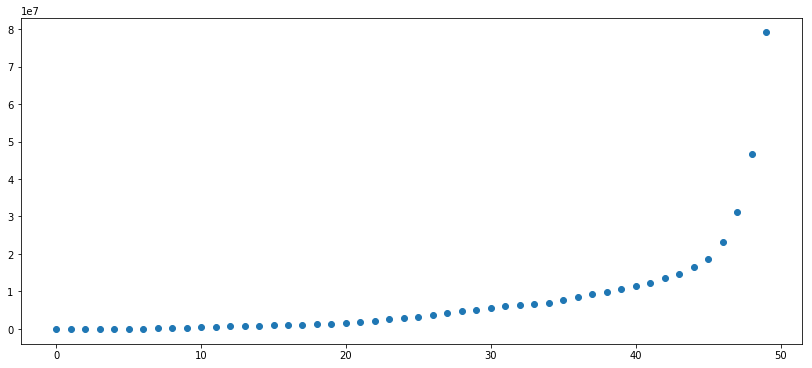

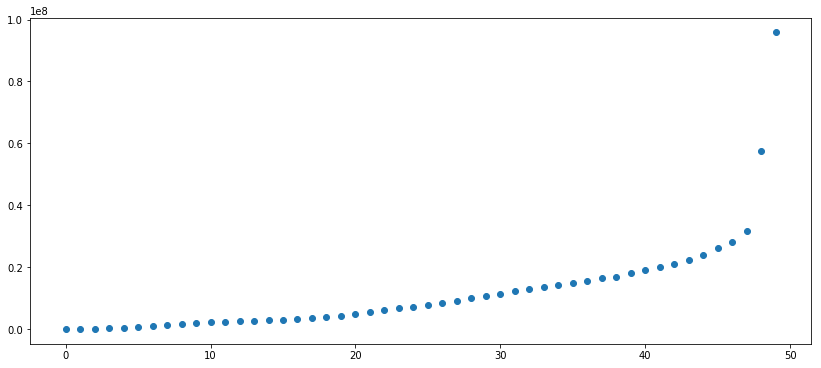

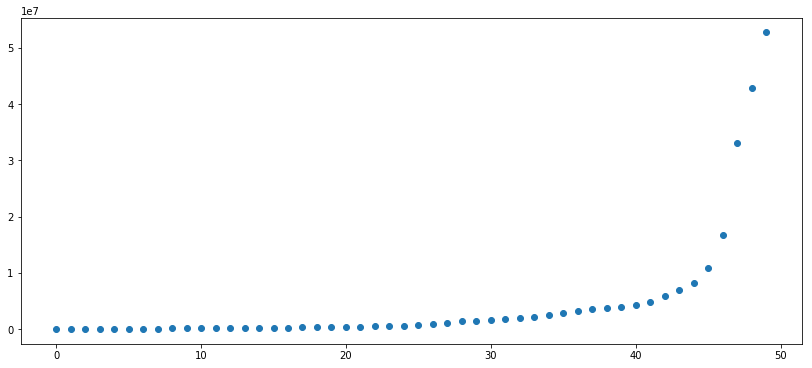

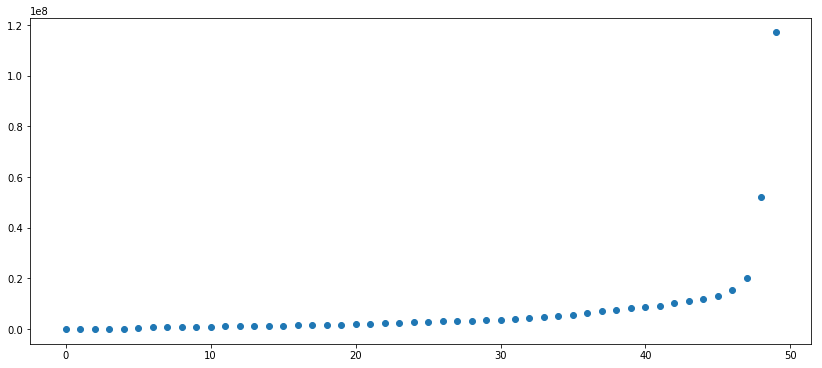

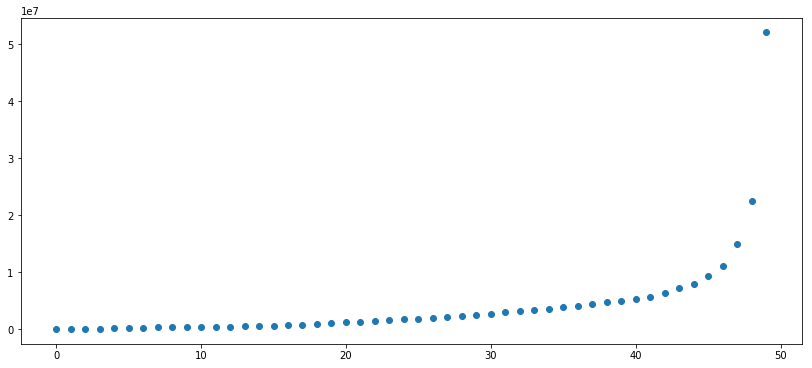

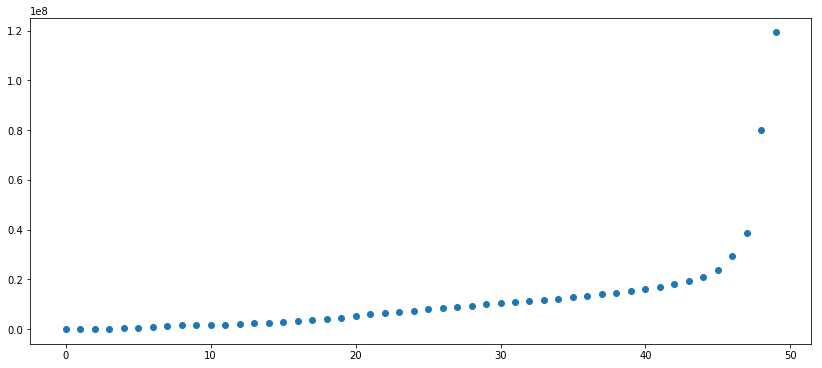

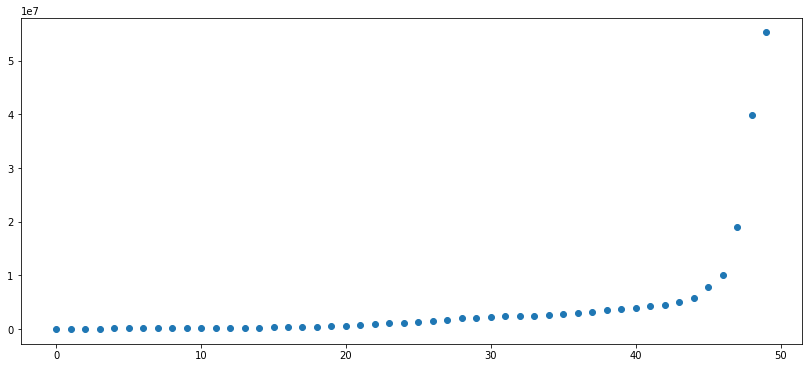

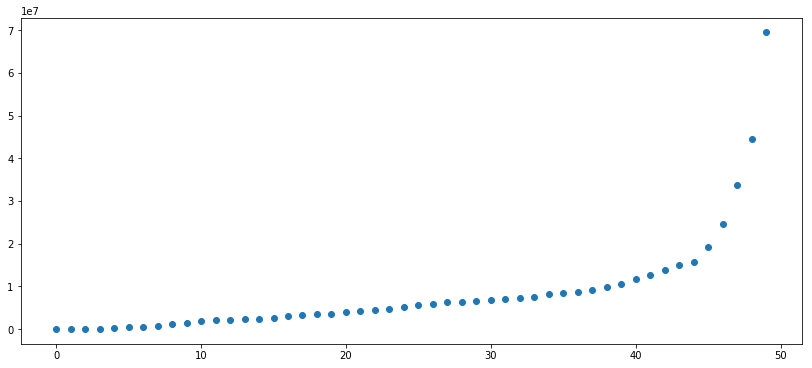

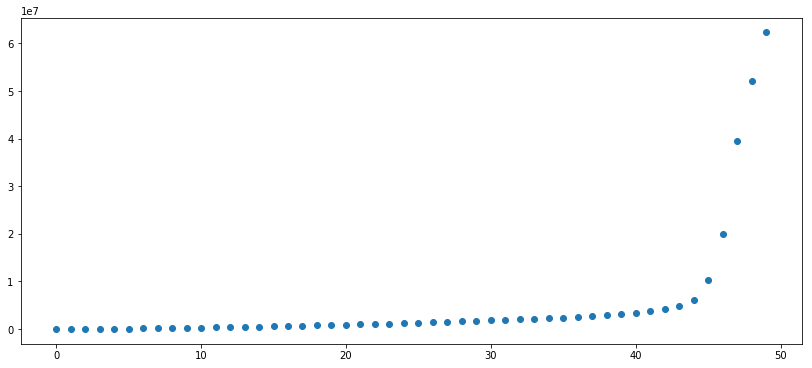

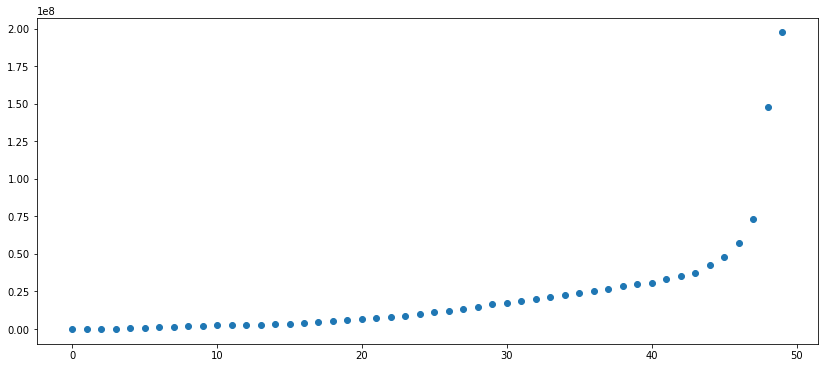

In [39]:
# finding market ids
market_ids = df_test['MarketId'].unique()

# creating 'time buckets'
df_test['time_bin'] = pd.qcut(df_test['time_dif'], q=50)
pd.DataFrame(df_test.groupby('time_bin')['TotalMatched'].agg('sum'))

for market in market_ids[:10]:
    plot_df = df_test.loc[df['MarketId']==market].copy()
    plot_df['time_bin'] = pd.qcut(plot_df['time_dif'], q=50, labels = False) # remove labels to infer time
    z = pd.DataFrame(plot_df.groupby('time_bin')['TotalMatched'].agg('sum'))
    plt.figure(figsize=(14,6))
    plt.scatter(z.index, z['TotalMatched'])

In [ ]:
# 0-20 every hour

In [ ]:
# plotting variation (SD) in prices over time

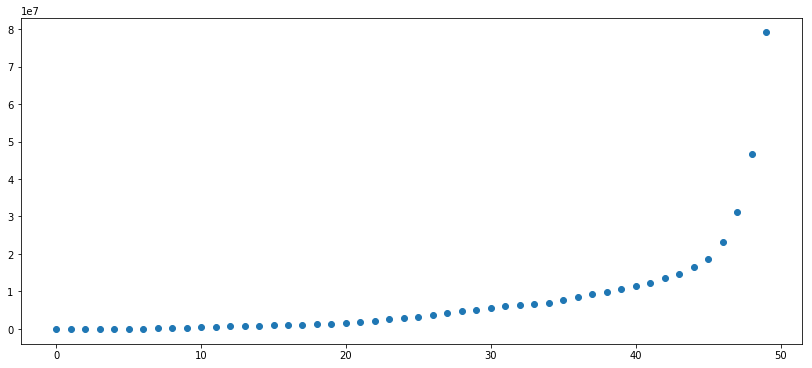

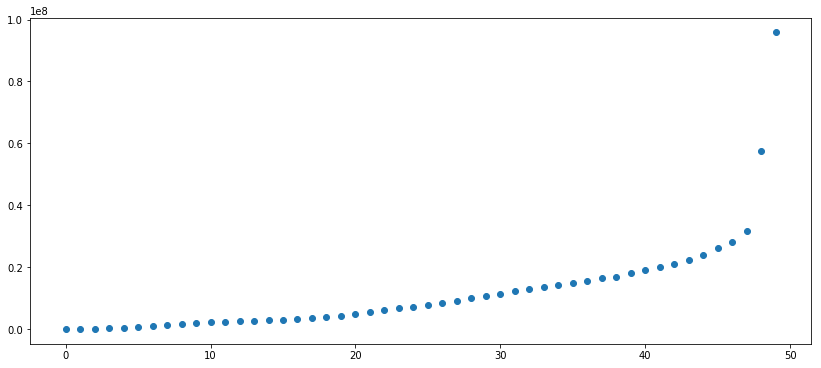

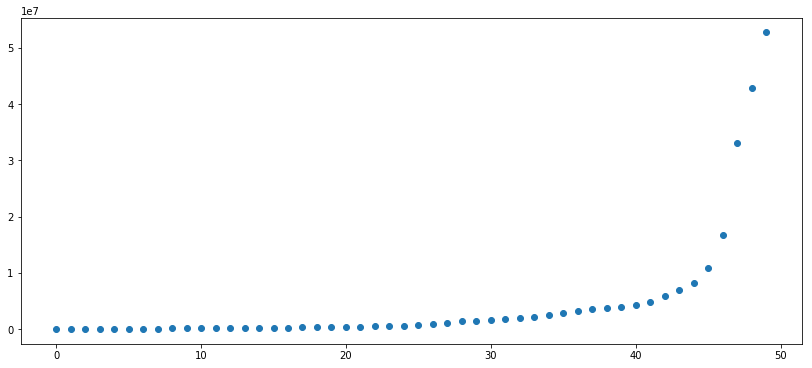

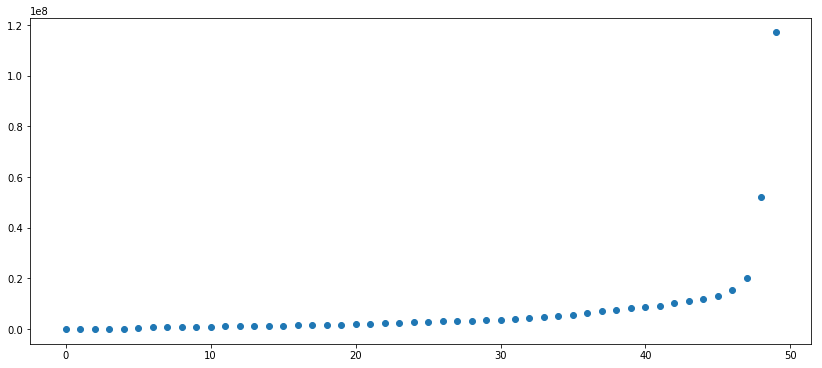

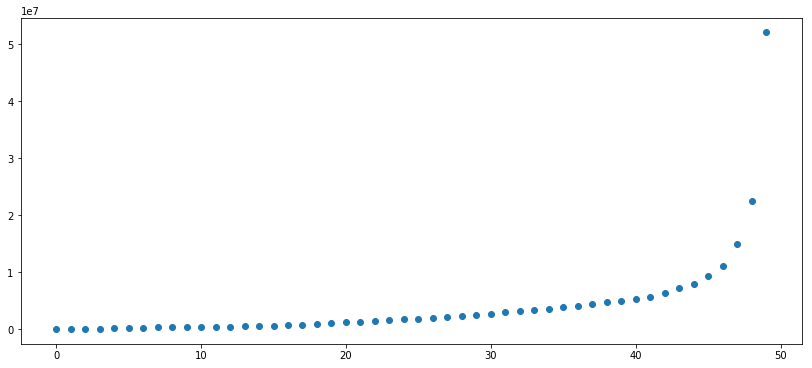

In [41]:
# creating 'time buckets'
df_test['time_bin'] = pd.qcut(df_test['time_dif'], q=50)
pd.DataFrame(df_test.groupby('time_bin')['LastPriceTraded'].agg('std'))

for market in market_ids[:5]:
    plot_df = df_test.loc[df['MarketId']==market].copy()
    plot_df['time_bin'] = pd.qcut(plot_df['time_dif'], q=50, labels = False) # remove labels to infer time
    z = pd.DataFrame(plot_df.groupby('time_bin')['TotalMatched'].agg('sum'))
    plt.figure(figsize=(14,6))
    plt.scatter(z.index, z['TotalMatched'])

In [ ]:
# both volume/price variation indicate something like:
0-20 [every hour?]
20-40 [every half hour?]
40-45 [every 10 mins]
then every 1min / 30 seconds if still before off
then every 10 seconds / second if inplay?

